# Projet 10: Détecter des faux billets (version Python)

## Objectifs:
    - Nettoyer les données et traiter les valeurs vides grace à une régression linéaire.
    - Comparer la méthode Kmeans et une régréssion logistique classique pour détecter les faux billets.
    - Déterminer le taux de faux positifs et de faux négatifs via une matrice de confusion.
    
    Projet commencé en juin 2022

# 1. Importation des bibliothèques et nettoyage des données

    On va importer le fichier permettant d'entrainer nos modèles, et le nettoyer, le modifier pour qu'il soit utilisable.
    
   ## 1a. Importation des biblothèques et des données, analyse sommaire

In [1]:
# coding: utf8
#permet d'utiliser l'encodage utf8

#importation des bibliothèques "générales"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from datetime import datetime as dt

sns.set()

#bibliothèque contenant des fonctions de clustering et dimensional reduction
    #(cercle de corrélation, dendrogramme, plans factoriels, éboulis des valeurs propres)
from P10_functions_clustering_pca_logistic_regression import *


#importation des bibliothèques de clustering:

from sklearn.preprocessing import StandardScaler #pour centrer et réduire les données
from sklearn.cluster import KMeans



#pour la pertinence des clusters (~scoring)
from sklearn.metrics.cluster import adjusted_rand_score

#régression linéaire
from sklearn.linear_model import LinearRegression

# linear regression with variable selection
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels
from scipy.stats import t, shapiro
import statsmodels.api as sm #pour homoscédasticité



#attribution des valeurs trouvées grace à la régression linéaire
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler #pour changer l'échelle des données pour traitement
from sklearn.preprocessing import LabelEncoder #pour changer les booléens en nombre

# Decision Tree
from sklearn.tree import DecisionTreeClassifier

# for the accuracy of the machine learning model and confusion matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# k-NN
from sklearn import neighbors

#pour séparer les données en training et testing test
from sklearn.model_selection import train_test_split


#importation des fichiers .csv en dataframe
billets = pd.read_csv('billets.csv', sep = ';')
billets_test = pd.read_csv('billets_production.csv', sep = ',')

In [2]:
# On remplace les booléens par des 0 et 1.

# Instantiate LabelEncoder
le = LabelEncoder()

# Encode single column status
billets.is_genuine = le.fit_transform(billets.is_genuine)

In [3]:
#Diverses opération pour voir l'allure de notre dataframe et voir les étapes nécessaires du nettoyage des données.
#C'est dans ses lignes qu'on voit le taux de vrai et faux billets, les dimensions moyennes...

#billets.describe()
#billets.shape
#billets[billets.duplicated()]
#billets.info()
#billets.head(20)
#billets_test

## 1b. Nettoyage des données : traitement des valeurs NaN (à l'aide d'une régression linéaire)

    Après avoir fait les tests basiques sur notre dataframe, on va utiliser une régression linéaire pour combler  
    les valeurs vides (présente uniquement dans la variable margin_low.
    
    On va donc faire une régression linéaire à partir des autres variables (pour pouvoir utiliser la variable is_genuine, on a convertit les booléens en 0 et 1).
    
### Principe de la régression linéaire:

    Une régression linéaire s'applique avec des données quantitatives. Le but est de trouver une droite modélisant le mieux les données, en réduisant la distance totale des points par 
    rapport à la droite.  
    Cette droite permet ainsi de prédire la coordonnées y associé à X.  
    
    
    La distance totale se calcule avec la somme des carrés résiduels (SSR) (le résidu étant la 
    distance entre la droite et le point). En effet, si on somme juste les distances telles 
    quelles, cette somme aura tendance à s'annuler: les distances des points en dessous de 
    la courbe étant négatifs, celles au-dessus étant positif.  
    La méthode des moindres carrés ordinaires (OLS) sert à optimiser cette somme.  
    
    Il faut noter ici que nous avons plus de deux dimensions, on fait donc une Régression
    Linéaire Multiple. Les maths et le principe restent les mêmes, si ce n'est que plutôt que
    d'avoir y = ax +b, nous avons y = a1x1 + a2x2... + b.
    
    
##### Précisions:

    Rôle du coefficient de détermination (R-squared):
    C'est le quotient de la Somme des Carrés Expliquée (la variation de y expliquée par le modèle) 
    par la Somme des Carrés Totale (qui traduit la variation totale de y).
    R-squared prend ses valeurs entre 0 et 1, s'il vaut 1 toute la variation est expliquée par le
    modèle, s'il vaut 0 aucune variation n'est expliquée par le modèle (mais peut l'être 
    avec un modèle différent). Basiquement, s'il n'est pas supérieur à 0.5, on rejette la 
    modélisation par la régression linéaire.    

    Rôle de la p-valeur (P>|t|): 
    C'est le résultat du test de significativité du paramètre, on a "le paramètre vaut 0" versus
    "le paramètre est différent de 0".
    A un niveau de test de 5%, si les p-valeurs sont inférieures à 0.05, on rejette l'hypothèse
    selon laquelle le paramètre est égal à 0: les paramètres concernés sont significatifs.
    On va tester les p-valeurs des différents paramètres, puis supprimer un paramètre 
    non-significatif à chaque iteration.
    Notons qu'il est préférable de ne garder que les variables les plus utiles pour optimiser
    l'efficacité de la prédiction et le coût en temps et en mémoire de l'algorithme (ici 
    on fait une procédure backward pour déterminer les variables nécessaires et suffisantes).

In [4]:
# dataframe without the NaN, so we can do the tests on it
billets2 = billets.dropna()
billets2.shape
billets2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1463 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1463 non-null   int64  
 1   diagonal      1463 non-null   float64
 2   height_left   1463 non-null   float64
 3   height_right  1463 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1463 non-null   float64
 6   length        1463 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 91.4 KB


In [5]:
# Retraits de données atypiques et influentes sur le modèle (après première analyse)
billets2 = billets2.drop([1441,1348])

In [6]:
# Après deuxième analyse et l'absence de confirmation de l'hypothèse vérifiant l'homoscédasticité, on va tester si cette
    # non confirmation vient bien du fait qu'il y ait des billets vrais et des billets faux. On va faire en annexe les tests
    # sur ces deux dataframes
billets2_vrai = billets2.loc[billets2['is_genuine'] == 1, :]
billets2_faux = billets2.loc[billets2['is_genuine'] == 0, :]
n_vrai = billets2_vrai.shape[0]
n_faux = billets2_faux.shape[0]

In [7]:
# On régresse margin_low en fonction de toutes les autres variables de l'échantillon, pour
    # observer les divers paramètres de cette régression.
reg_multi = smf.ols('margin_low~margin_up+height_left+height_right+length+diagonal+is_genuine',
                    data=billets2).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     389.5
Date:                Tue, 12 Jul 2022   Prob (F-statistic):          2.67e-298
Time:                        15:48:03   Log-Likelihood:                -766.26
No. Observations:                1461   AIC:                             1547.
Df Residuals:                    1454   BIC:                             1584.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.6870      8.278      0.325   

Certains paramètres ne sont pas significatif (p-valeur supérieure à 0.05).

Le R² vaut 0.617, le R² ajusté vaut 0.615: même s'il reste éloigné de 1, il reste supérieur à 0.5: on peut utiliser le modèle de régression linéaire multiple.

### On retire les variables non significatives

In [8]:
# on a retiré length, de p-valeur de 0.868 (ce paramètre est le moins significatif de tous)
reg_multi = smf.ols('margin_low~margin_up+height_left+height_right+diagonal+is_genuine', data=billets2).fit()
#print(reg_multi.summary())

# retrait de diagonal p-valeur de 0.719
reg_multi = smf.ols('margin_low~margin_up+height_left+height_right+is_genuine', data=billets2).fit()
#print(reg_multi.summary())

# retrait de height_right p-valeur de 0.496
reg_multi = smf.ols('margin_low~margin_up+height_left+is_genuine', data=billets2).fit()
#print(reg_multi.summary())

# retrait de height_left p-valeur de 0.454
reg_multi = smf.ols('margin_low~margin_up+is_genuine', data=billets2).fit()
#print(reg_multi.summary())

In [9]:
# En résumé:
reg_multi = backward_selected(billets2[billets2.columns], 'margin_low')

_______________________________
margin_low ~ margin_up + height_left + diagonal + height_right + length + is_genuine + 1
remove length (p-value : 0.899 )

_______________________________
margin_low ~ margin_up + height_left + diagonal + height_right + is_genuine + 1
remove diagonal (p-value : 0.786 )

_______________________________
margin_low ~ margin_up + height_left + height_right + is_genuine + 1
remove height_left (p-value : 0.575 )

_______________________________
margin_low ~ margin_up + height_right + is_genuine + 1
remove height_right (p-value : 0.455 )

_______________________________
margin_low ~ margin_up + is_genuine + 1
is the final model !

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     1171.
Date:               

    Les deux variables restantes, margin_up et is_genuine, sont significatives.
    On passe à l'analyse des résultats.

### Analyse des résultats du modèle

On réalise les tests à un niveau de $\alpha=5\%$.
    La taille n de l'échantillon est de 1463 et le nombre de variable p restantes est de 3.

    Les deux premiers tests (calcul des résidus studentisés et la distance de Cook) ont pour but de déterminer s'il y a des points qui sont à la fois influants et atypiques.
    (Ces points peuvent influencer grandement (et négativement) sur la pertinence de la droite de regression)


In [10]:
alpha = 0.05
n = billets2.shape[0]
p = 3
analyses = pd.DataFrame({'obs':np.arange(1, n+1)})

#### Calcul des leviers

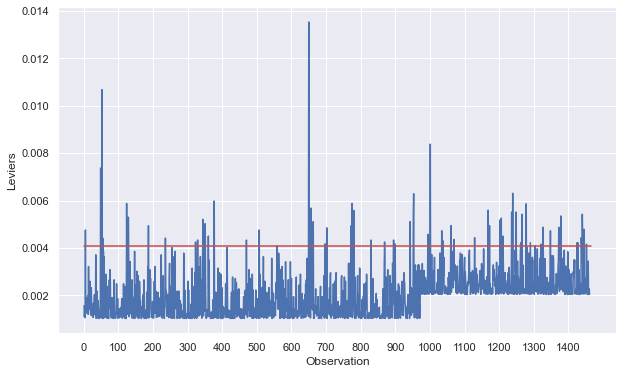

In [11]:
analyses['levier'] = reg_multi.get_influence().hat_matrix_diag

seuil_levier = 2*p/n

plt.figure(figsize=(10,6))
plt.plot(analyses['obs'], analyses['levier'])
plt.xticks(np.arange(0, 1465, step=100))
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, 1465], [seuil_levier, seuil_levier], color='r')
plt.show()

In [12]:
# Sélection des points pour lesquels le levier est supérieur au seuil (observations atypiques sur variables explicatives):
analyses.loc[analyses['levier'] > seuil_levier, :].head(5)

,obs,levier
4,5,0.004762
48,49,0.007378
52,53,0.010683
54,55,0.004421
123,124,0.005884


#### Calcul des résidus studentisés

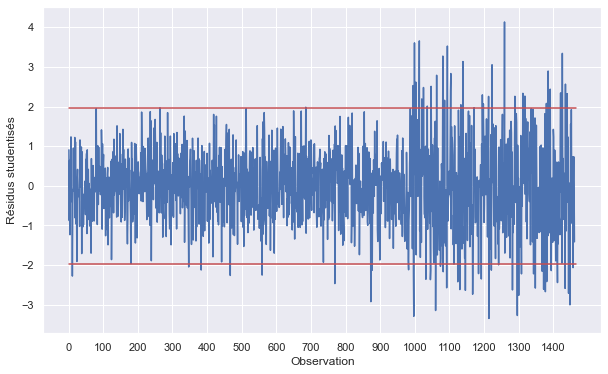

In [13]:
analyses['rstudent'] = reg_multi.get_influence().resid_studentized_internal
seuil_rstudent = t.ppf(1-alpha/2,n-p-1)

plt.figure(figsize=(10,6))
plt.plot(analyses['obs'], analyses['rstudent'])
plt.xticks(np.arange(0, 1465, step=100))
plt.xlabel('Observation')
plt.ylabel('Résidus studentisés')
plt.plot([0, 1465], [seuil_rstudent, seuil_rstudent], color='r')
plt.plot([0, 1465], [-seuil_rstudent, -seuil_rstudent], color='r')
plt.show()

In [14]:
# Sélection des points pour lesquels les résidus sont hors des limites du seuil
    #(observations atypiques sur variable expliquée):
analyses.loc[analyses['rstudent'] > seuil_rstudent]
analyses.loc[analyses['rstudent'] < -seuil_rstudent].head(5)

,obs,levier,rstudent
10,11,0.001362,-2.275315
346,347,0.003569,-2.045632
382,383,0.001110,-2.122636
466,467,0.002232,-2.259958
558,559,0.002547,-2.250396


#### Distance de Cook

(1461, 4)


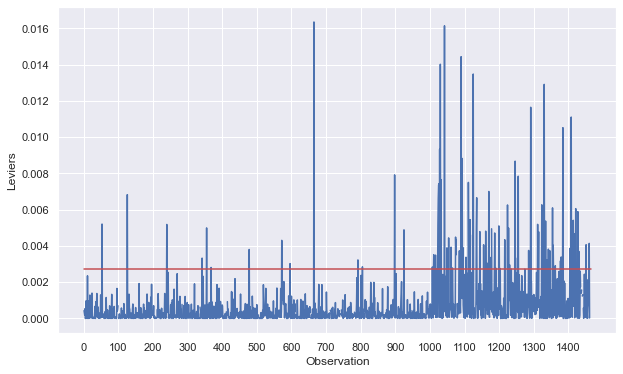

In [15]:
# On trouve la distance de Cook:
influence = reg_multi.get_influence().summary_frame()

# Le seuil de la distance de Cook est de (n-p)
analyses['dcooks'] = influence['cooks_d']
seuil_dcook = 4/(n-p)
print(analyses.shape)

# On detecte les observations influentes:
plt.figure(figsize=(10,6))
plt.plot(analyses['obs'], analyses['dcooks'])
plt.xticks(np.arange(0, 1465, step=100))
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, 1465], [seuil_dcook, seuil_dcook], color='r')
plt.show()

In [16]:
#Sélection des points pour lesquels la distance de Cook est supérieure au seuil (observation de l'influence des variables):

analyses.loc[analyses['dcooks'] > seuil_dcook, :].head(5)

,obs,levier,rstudent,dcooks
52,53,0.010683,-1.203072,0.005210
125,126,0.001205,0.673530,0.006830
239,240,0.001673,-0.222311,0.005187
341,342,0.001711,1.143508,0.003330
354,355,0.001205,-1.477340,0.004996


In [17]:
# dataframe regroupant les valeurs atypiques et influentes
retrait = analyses.loc[analyses['dcooks'] > seuil_dcook, :]
retrait = retrait.loc[retrait['levier'] > seuil_levier, :]
retrait1 = retrait.loc[retrait['rstudent'] > seuil_rstudent]
retrait2 = retrait.loc[retrait['rstudent'] < -seuil_rstudent]
print(retrait1)
print(retrait2)

Empty DataFrame
Columns: [obs, levier, rstudent, dcooks]
Index: []
Empty DataFrame
Columns: [obs, levier, rstudent, dcooks]
Index: []


#### Colinéarité des variables
    Notre droite (des Moindre Carrés Ordinaires) existe ssi toutes les variables sont non-colinéaires entres elles.
    On utilise l'indicateur VIF (Variance Inflation Factor): si les valeurs sont supérieures à 10, on a un problème de 
    colinéarité.
    S'il y a un problème, cela signifie qu'il peut y avoir plusieurs droites possibles issues de la méthodes de Moindres 
    Carrés Ordinaires.
    Ce qui n'est heureusement pas le cas ici.

In [18]:
variables = reg_multi.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]
# les deux coefficients sont inférieurs à 10, il n'y a pas de problème de colinéarité.

[1.5994548540750209, 1.5994548540750204]

#### homoscédasticité
    C'est l'étude de la constance de la variance des résidus. Dans une régression linéaire, les erreurs doivent être
    constante, c'est-à-dire qu'on doit avoir une situation d'homoscédasticité.

In [19]:
from statsmodels.compat import lzip
import statsmodels.stats.api as sms

#perform Bresuch-Pagan test
names = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breuschpagan(reg_multi.resid, reg_multi.model.exog)

lzip(names, test)


[('Lagrange multiplier statistic', 160.12826867043435),
 ('p-value', 1.6927322163849056e-35),
 ('f-value', 89.73483322713014),
 ('f p-value', 1.7657362296842874e-37)]

In [20]:
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(reg_multi.resid, variables)
print('p value test Breusch Pagan:', pval)

p value test Breusch Pagan: 1.6927322163849056e-35


La p-valeur ici est inférieure à $5$%, on rejette l'hypothèse $H0$ selon laquelle les variances sont constantes (l'hypothèse d’homoscédasticité).
Nous sommes dans une situation d'hétéroscédasticité, ce qui rend la régression linéaire théoriquement invalide.

Il est en effet impossible ici d'avoir l'hypothèse $H0$ vérifiée, car la variance de nos résidus n'est pas la même selon que les billets soient vrais ou faux.

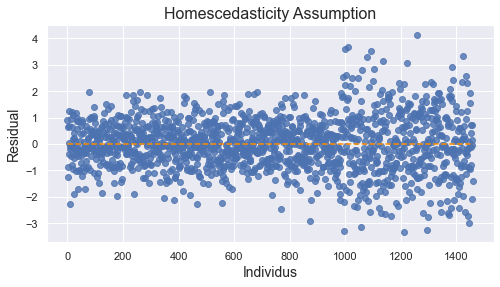

In [21]:
# Plotting the residuals
plt.subplots(figsize=(8, 4))
plt.scatter(x=analyses.index, y=analyses.rstudent, alpha=0.8)
plt.plot(np.repeat(0, len(analyses.index)+2), color='darkorange', linestyle='--')

plt.ylabel('Residual', fontsize=14)
plt.xlabel('Individus', fontsize=14)
plt.title('Homescedasticity Assumption', fontsize=16)
plt.show() 

    Cependant, si la p-valeur est faible, on voit sur le graphe entre les individus et les résidus que la distribution reste symétrique. On peut quand même admettre l'hypothèse, et accepter que le modèle linéaire n'est pas absurde dans 
    notre cas.

#### test de la normalité des résidus

In [22]:
shapiro(reg_multi.resid)

ShapiroResult(statistic=0.9938796162605286, pvalue=1.0030525118054356e-05)

Ici, l'hypothèse de normalité est remise en cause (p-value < 0.05).

Néanmoins, l'observation des résidus, le fait qu'ils ne soient pas très différents d'une distribution symétrique, et le fait que l'échantillon soit de taille suffisante (supérieure à 30) permettent de dire que les résultats obtenus par le modèle linéaire gaussien ne sont pas absurdes, même si le résidu n'est pas considéré comme étant gaussien.

### Application du modèle à la dataframe principale

In [23]:
billets3 = billets[billets.isna().any(axis=1)]

# On utilise le modèle pour prédire les données
prediction = reg_multi.predict(billets3)

# On utilise IterativeImputer pour remplacer les NaN par les valeurs prédite dans la dataframe principale
ite_imp = IterativeImputer()
ite_imp.fit(billets, prediction)
billets = ite_imp.transform(billets)
billets = pd.DataFrame(billets, columns=billets3.columns)

#ix = billets3.index
#billets.loc[ix, "margin_low"]

# 2. Création et entrainement des modèles de détection des faux billets: utilisation des méthodes Kmeans et régression logistique.

    On entre dans le coeur du sujet: à l'aide du fichier de référence que l'on vient de nettoyer, on va créer des modèles, que nous allons ensuite comparer, permettant de prédire si le billet est un vrai ou un faux.  
    Nous allons utiliser respectivement la régression logisitique, puis la méthode du Kmeans.
    On affichera enfin une matrice de confusion pour évaluer les modèles: affichage des faux positifs et négatifs.

## 2.a Régression logistique (binomial logistic regression in our case)

### Principe de la régression logistique:
    
    Cette méthode de classification ressemble beaucoup sur le principe à celui de la régression linéaire, mais où l'on cherche à prédire une variable qualitative. Si l'on cherche à prédire une variable qualitative, une droite ne fera l'affaire que pour les extrêmes, et encore.  
    La régression logistique utilise une courbe sigmoïde (dépendante de l'inverse d'une fonction exponentielle) pour modéliser ces données.  
    On se sert ensuite de cette courbe pour, à partir d'un X, trouver un y qui sera une Probabilité de Classification.  
    Au début et à la fin de la courbe, on a des valeurs proches de 0 et 100% respectivement, tandis que la partie centrale présente plus d'incertitudes.  
    
    Lorsqu'il y a plus de deux classes dans la variable qualitative (faible, moyen, fort par exemple), on fait de la regression multinomiale. Une des façons de gérer ce cas est l'algorithme du One-VS-Rest (OVR).

In [24]:
# Sélectionne toutes les colonnes sauf is_genuine
cols_X = [c for c in billets.columns if c != "is_genuine"]

# y est la variable qui est prédite à partir de X (X est l'ensemble des régresseurs).
X = billets[cols_X]
y = billets['is_genuine']

# Rescale the data (every variable need to have the same weight)
scaler = MinMaxScaler(feature_range=(0,1))
rescaledX = scaler.fit_transform(X)

# Convert X back to a Pandas DataFrame, for convenience
X = pd.DataFrame(rescaledX, columns=X.columns)

# Split into test and training sets (70/30)
test_size = 0.3
seed = 0
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=test_size, random_state=seed)

In [25]:
# Building of the logistic regression model
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

LogisticRegression()

LogisticRegression 0.9866666666666667
LogisticRegression 0.9911111111111112


<AxesSubplot:>

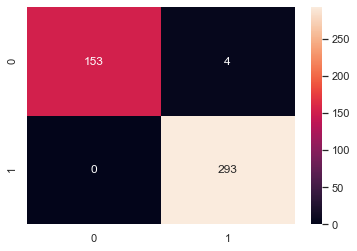

In [26]:
# Application du modèle et analyse des performances:

# Check the model performance with the training data (it should always be high, since it's its own reference)
predictions_lr = model_lr.predict(X_train)
print("LogisticRegression", accuracy_score(y_train, predictions_lr))

# Check the model performance with the testing data
predictions_lr = model_lr.predict(X_test)#we can call predictions_lr as y_pred for clarity?
print("LogisticRegression", accuracy_score(y_test, predictions_lr))

# Check the model performance with the confusion matrix
confusion_matrix_lr = confusion_matrix(y_test, predictions_lr)
sns.heatmap(confusion_matrix_lr, annot=True, fmt='d')
#print(confusion_matrix_lr)

### Application au "vrai" jeu de données:

In [27]:
# Dataframe with the data to analyse
billets_test_lr = billets_test
X_pred_lr = billets_test_lr[["diagonal", "height_left", "height_right", "margin_low", "margin_up", "length"]]

# Rescale the data(same pound for every variable)
scaler = MinMaxScaler(feature_range=(0,1))
rescaledX_pred_lr = scaler.fit_transform(X_pred_lr)

# Convert X back to a Pandas DataFrame, for convenience
X_pred_lr = pd.DataFrame(rescaledX_pred_lr, columns=X_pred_lr.columns)

# Application du modèle de prédiction
y_pred_lr = model_lr.predict(X_pred_lr)


# Stockage des résultats dans des variables du dataframe, puis affichage.
billets_test_lr["prediction"] = y_pred_lr
billets_test_lr["is_genuine"] = billets_test_lr["prediction"].apply(lambda x : "Faux billet" if x == 0 else "Vrai billet")
billets_test_lr

,diagonal,height_left,height_right,margin_low,margin_up,length,id,prediction,is_genuine
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,0.0,Faux billet
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,0.0,Faux billet
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,0.0,Faux billet
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,1.0,Vrai billet
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,1.0,Vrai billet


## 2.b K-Means

### Principe du K-means:

    Le K-means est une méthode de clustering: il va regrouper les données en un nombre de groupes prédéfinis grâce à des centroïdes (qui seront le centre de gravité de chaque groupe). Dans notre cas, on veut diviser nos données en deux groupes: l'un qui regrouperait les faux billets, l'autre les vrais.  
    
    Le principe de fonctionnement repose en premier lieu sur la distribution aléatoire d'un nombre de centroïdes. Une fois répartis, les centroïdes vont considérer comme faisant partie de leur groupe tous les points les plus proches d'eux.  
    Une fois les groupes définis, les centroïdes sont déplacés au centre des groupes, puis ils vont de nouveau tester  
    si tous les points les plus proches d'eux font partis de leur groupe. Les centroïdes sont alors redéplacés au centre  
    de ces nouveaux groupes, et on répète l'opération jusqu'à ce que les groupes soient identiques à chaque futur essai.  
    On renouvelle ce test un certain nombre de fois en repositionnant les centroïdes aléatoirement, et on séléctionne la  
    position qui minime la variance totale.  
    
    
    Note: le display parallel coordinates nous permet d'observer les spécialisations de chaque clusters. 


In [28]:
# Préparation des données pour le Kmeans et spliting training/test sets (relativement optionnel)

# y est la variable qui est prédite à partir de X.
X_kmeans = X
y_kmeans = y

#Centrage et réduction
std_scale = StandardScaler().fit(X_kmeans)
X_scaled = std_scale.transform(X_kmeans)

# Convert X back to a Pandas DataFrame, for convenience
X_kmeans = pd.DataFrame(X_scaled, columns=X_kmeans.columns)

# Split into test and training sets
X_train_km, X_test_km, y_train_km, y_test_km =  train_test_split(X_kmeans, y_kmeans, test_size=test_size,
                                                                 random_state=seed)

In [29]:
# Training set:

# Create a k-means clustering model
kmeans = KMeans(n_clusters=2, n_init=10, random_state = seed)

# Fit the data to the model
kmeans.fit(X_train_km)

# Determine which clusters each data point belongs to:
km_clusters =  kmeans.predict(X_train_km)

# Add cluster number to the original data
X_scaled_clustered = pd.DataFrame(X_train_km, columns=X_train_km.columns, index=X_train_km.index)
X_scaled_clustered['cluster'] = km_clusters

# Vérification de la pertinence des clusters (proche de 1 prouve que les clusters sont fiables)
print(adjusted_rand_score(y_train_km , km_clusters))

# Check the model performance with the training data
print("Kmeans", accuracy_score(y_train_km, km_clusters))


0.9390117063679185
Kmeans 0.9847619047619047


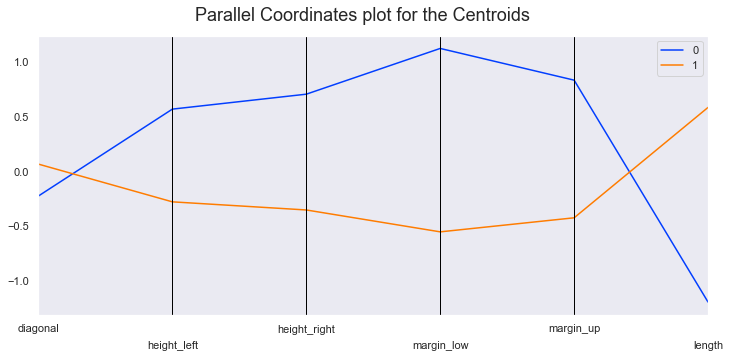

In [30]:
# Mise en évidence des caractéristiques de chaque cluster

# Display parallel coordinates plots, one for each cluster
#display_parallel_coordinates(X_scaled_clustered, 2)

# Create a data frame containing our centroids
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X_kmeans.columns)
centroids['cluster'] = centroids.index

# Display parallel coordinates plots, one for each centroid cluster
display_parallel_coordinates_centroids(centroids, 2)

<AxesSubplot:>

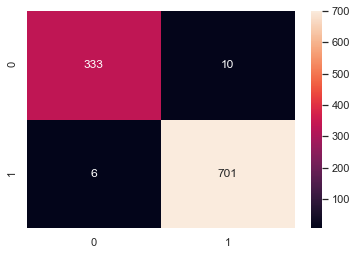

In [31]:
# Check the model performance with the confusion matrix

confusion_matrix_km = confusion_matrix(y_train_km, km_clusters)
sns.heatmap(confusion_matrix_km, annot=True, fmt='d')
#print(confusion_matrix_km)

# Note: les grands nombres sur la diagonale sont les positifs, dans le cas ils sont inversé il suffit de manipuler pour  
    #attribuer 0 et 1 au bon cluster

0.9294346193556269
Kmeans 0.9822222222222222


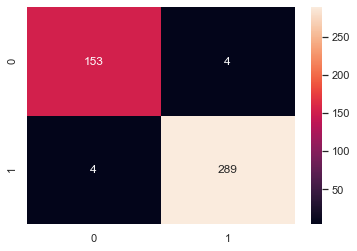

In [32]:
# Testing set

# Create a k-means clustering model
kmeans_test = KMeans(n_clusters=2, n_init=10, random_state = seed)


# Fit the data to the model
kmeans_test.fit(X_test_km)

# Determine which clusters each data point belongs to:
km_clusters_test =  kmeans_test.predict(X_test_km)

# Add cluster number to the original data
X_scaled_clustered_test = pd.DataFrame(X_test_km, columns=X_test_km.columns, index=X_test_km.index)
X_scaled_clustered_test['cluster'] = km_clusters_test

# Vérification de la pertinence des clusters
print(adjusted_rand_score(y_test_km , km_clusters_test))

# Check the model performance with the confusion matrix
confusion_matrix_km = confusion_matrix(y_test_km, km_clusters_test)
sns.heatmap(confusion_matrix_km, annot=True, fmt='d')
#print(confusion_matrix_km)

# Check the model performance with the test data
print("Kmeans", accuracy_score(y_test_km, km_clusters_test))

In [33]:
# Mise en évidence des caractéristiques de chaque cluster testing set (même chose que dans le training set)

# Display parallel coordinates plots, one for each cluster
#display_parallel_coordinates(X_scaled_clustered_test, 2)

# Create a data frame containing our centroids
#centroids = pd.DataFrame(kmeans_test.cluster_centers_, columns=X_kmeans.columns)
#centroids['cluster'] = centroids.index

# Display parallel coordinates plots, one for each centroid cluster
#display_parallel_coordinates_centroids(centroids, 2)

### Application au "vrai" jeu de données:

In [34]:
# Dataframe with the data to analyse
billets_test_km = billets_test
X_pred_km = billets_test_km[["diagonal", "height_left", "height_right", "margin_low", "margin_up", "length"]]

#Centrage et réduction
std_scale = StandardScaler().fit(X_pred_km)
X_scaled_test = std_scale.transform(X_pred_km)

# Convert X back to a Pandas DataFrame, for convenience
X_pred_km = pd.DataFrame(X_scaled_test, columns=X_pred_km.columns)

# Determine which clusters each data point belongs to:
y_pred_km =  kmeans.predict(X_pred_km)

# Stockage des résultats dans des variables du dataframe, puis affichage.
billets_test_km["prediction"] = y_pred_km
billets_test_km["is_genuine"] = billets_test_km["prediction"].apply(lambda x : "Faux billet" if x == 0 else "Vrai billet")
billets_test_km

,diagonal,height_left,height_right,margin_low,margin_up,length,id,prediction,is_genuine
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,0,Faux billet
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,0,Faux billet
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,0,Faux billet
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,1,Vrai billet
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,1,Vrai billet


## 2.c Decision Tree

### Principe du Decision Tree:


In [35]:
# On réutilise les même données que dans le modèle de regression logistique
#X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=test_size, random_state=seed)

# Build a decision tree model
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train, y_train)

# Check the model performance with the training data
predictions_dt = model_dt.predict(X_train)
print("DecisionTreeClassifier", accuracy_score(y_train, predictions_dt))

# Check the model performance with the test data
predictions_dt = model_dt.predict(X_test)
print("DecisionTreeClassifier", accuracy_score(y_test, predictions_dt))

DecisionTreeClassifier 1.0
DecisionTreeClassifier 0.9711111111111111


In [36]:
# Dataframe with the data to analyse
billets_test_dt = billets_test
X_pred_dt = billets_test_dt[["diagonal", "height_left", "height_right", "margin_low", "margin_up", "length"]]

# Rescale the data(same pound for every variable)
scaler = MinMaxScaler(feature_range=(0,1))
rescaledX_pred_dt = scaler.fit_transform(X_pred_dt)

# Convert X back to a Pandas DataFrame, for convenience
X_pred_dt = pd.DataFrame(rescaledX_pred_dt, columns=X_pred_dt.columns)

# Application du modèle de prédiction
y_pred_dt = model_dt.predict(X_pred_dt)


# Stockage des résultats dans des variables du dataframe, puis affichage.
billets_test_dt["prediction"] = y_pred_dt
billets_test_dt["is_genuine"] = billets_test_dt["prediction"].apply(lambda x : "Faux billet" if x == 0 else "Vrai billet")
billets_test_dt

,diagonal,height_left,height_right,margin_low,margin_up,length,id,prediction,is_genuine
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,0.0,Faux billet
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,0.0,Faux billet
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,0.0,Faux billet
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,1.0,Vrai billet
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,1.0,Vrai billet


## 2.d k-NN

### Principe du k-NN:


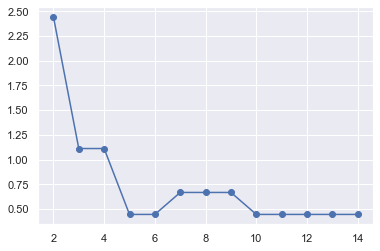

In [37]:
# On teste des k-NN pour différentes valeurs de k. On trace ensuite le pourcentage d'erreurs selon k.

errors = []
for k in range(2,15):
    model_knn = neighbors.KNeighborsClassifier(k)
    errors.append(100*(1 - model_knn.fit(X_train, y_train).score(X_test, y_test)))
plt.plot(range(2,15), errors, 'o-')
plt.show()

In [38]:
# On récupère le classifieur le plus performant

model_knn = neighbors.KNeighborsClassifier(n_neighbors=5)
model_knn.fit(X_train, y_train)

KNeighborsClassifier()

In [39]:
# Check the model performance with the test data
predictions_knn = model_knn.predict(X_test)
print("k-NN", accuracy_score(y_test, predictions_knn))

# Other method
error = 1 - model_knn.score(X_test, y_test)
print('Erreur: %f' % error)

k-NN 0.9955555555555555
Erreur: 0.004444


In [40]:
# Dataframe with the data to analyse
billets_test_knn = billets_test
X_pred_knn = billets_test_knn[["diagonal", "height_left", "height_right", "margin_low", "margin_up", "length"]]

# Rescale the data(same pound for every variable)
scaler = MinMaxScaler(feature_range=(0,1))
rescaledX_pred_knn = scaler.fit_transform(X_pred_knn)

# Convert X back to a Pandas DataFrame, for convenience
X_pred_knn = pd.DataFrame(rescaledX_pred_knn, columns=X_pred_knn.columns)

# Application du modèle de prédiction
y_pred_knn = model_knn.predict(X_pred_knn)


# Stockage des résultats dans des variables du dataframe, puis affichage.
billets_test_knn["prediction"] = y_pred_knn
billets_test_knn["is_genuine"] = billets_test_knn["prediction"].apply(lambda x : "Faux billet" if x == 0 else "Vrai billet")
billets_test_knn

,diagonal,height_left,height_right,margin_low,margin_up,length,id,prediction,is_genuine
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,0.0,Faux billet
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,0.0,Faux billet
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,0.0,Faux billet
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,1.0,Vrai billet
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,1.0,Vrai billet


# Notes, tests, exemples et bouts de codes inutiles ou non utilisés

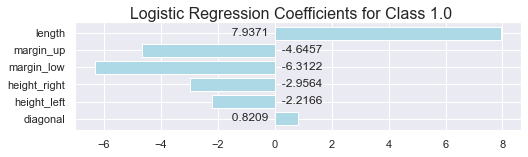

In [41]:
# Montre l'influence de chaque variable dans le processus de prédiction
logisticRegressionSummary(model_lr, X.columns)

_______________________________
margin_low ~ margin_up + height_left + diagonal + height_right + length + is_genuine + 1
remove height_left (p-value : 0.895 )

_______________________________
margin_low ~ margin_up + diagonal + height_right + length + is_genuine + 1
remove height_right (p-value : 0.308 )

_______________________________
margin_low ~ margin_up + diagonal + length + is_genuine + 1
remove is_genuine (p-value : 0.306 )

_______________________________
margin_low ~ margin_up + diagonal + length + 1
remove diagonal (p-value : 0.216 )

_______________________________
margin_low ~ margin_up + length + 1
remove length (p-value : 0.21 )

_______________________________
margin_low ~ margin_up + 1
remove margin_up (p-value : 0.06 )

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:        

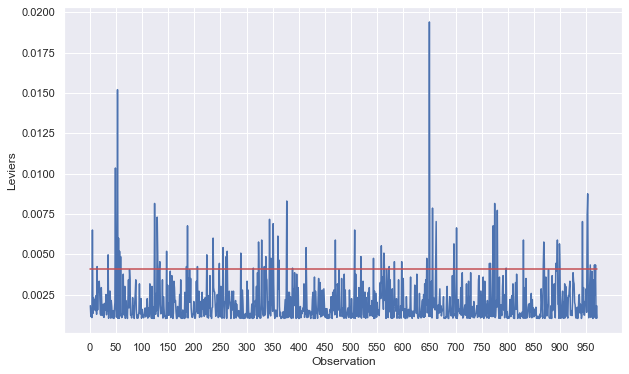

In [42]:
#Refaire les étapes avec les vrais billets puis les faux billets, et valider les hypothèses
reg_multi_vrai = backward_selected(billets2_vrai[billets2_vrai.columns], 'margin_low')
analyses_vrai = pd.DataFrame({'obs':np.arange(1, n_vrai+1)})
p_vrai = 2
# levier
analyses_vrai['levier'] = reg_multi_vrai.get_influence().hat_matrix_diag

seuil_levier_vrai = 2*p_vrai/n_vrai

plt.figure(figsize=(10,6))
plt.plot(analyses_vrai['obs'], analyses_vrai['levier'])
plt.xticks(np.arange(0, 971, step=50))
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, 971], [seuil_levier_vrai, seuil_levier_vrai], color='r')
plt.show()

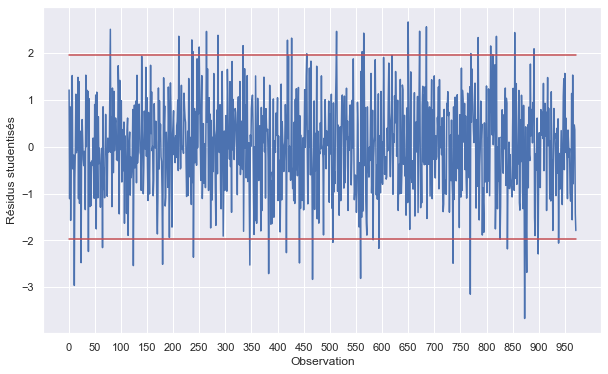

In [43]:
# résidus studentisés
analyses_vrai['rstudent'] = reg_multi_vrai.get_influence().resid_studentized_internal
seuil_rstudent_vrai = t.ppf(1-alpha/2,n_vrai-p_vrai-1)

plt.figure(figsize=(10,6))
plt.plot(analyses_vrai['obs'], analyses_vrai['rstudent'])
plt.xticks(np.arange(0, 971, step=50))
plt.xlabel('Observation')
plt.ylabel('Résidus studentisés')
plt.plot([0, 971], [seuil_rstudent_vrai, seuil_rstudent_vrai], color='r')
plt.plot([0, 971], [-seuil_rstudent_vrai, -seuil_rstudent_vrai], color='r')
plt.show()

(971, 4)


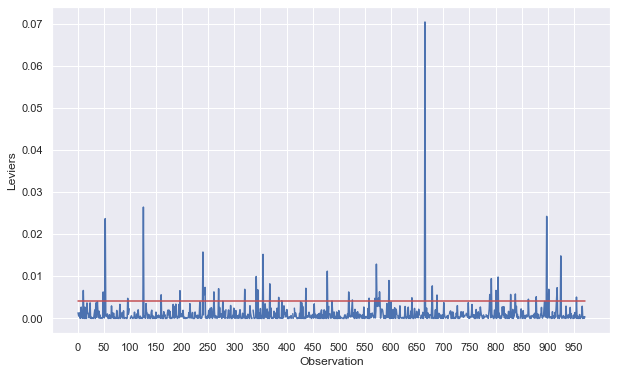

In [44]:
# Distance de Cook:
influence_vrai = reg_multi_vrai.get_influence().summary_frame()

# Le seuil de la distance de Cook est de (n-p)
analyses_vrai['dcooks'] = influence_vrai['cooks_d']
seuil_dcook_vrai = 4/(n_vrai-p_vrai)
print(analyses_vrai.shape)

# On detecte les observations influentes:
plt.figure(figsize=(10,6))
plt.plot(analyses_vrai['obs'], analyses_vrai['dcooks'])
plt.xticks(np.arange(0, 971, step=50))
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, 971], [seuil_dcook_vrai, seuil_dcook_vrai], color='r')
plt.show()

In [45]:
# colinéarité des variables
variables_vrai = reg_multi_vrai.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables_vrai.shape[1])]
# les deux coefficients sont inférieurs à 10, il n'y a pas de problème de colinéarité.

[1.5994548540750209]

p value test Breusch Pagan: 0.3307519242679467


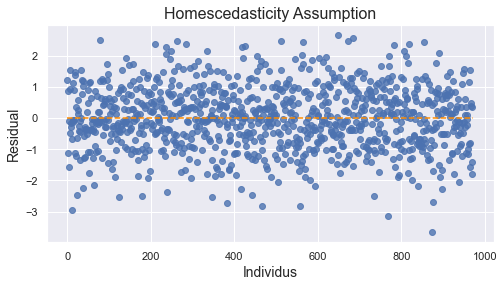

In [46]:
# homoscédasticité
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(reg_multi_vrai.resid, variables_vrai)
print('p value test Breusch Pagan:', pval)

# Plotting the residuals
plt.subplots(figsize=(8, 4))
plt.scatter(x=analyses_vrai.index, y=analyses_vrai.rstudent, alpha=0.8)
plt.plot(np.repeat(0, len(analyses_vrai.index)+2), color='darkorange', linestyle='--')

plt.ylabel('Residual', fontsize=14)
plt.xlabel('Individus', fontsize=14)
plt.title('Homescedasticity Assumption', fontsize=16)
plt.show() 

In [47]:
# Normalité des résidus
shapiro(reg_multi_vrai.resid)

ShapiroResult(statistic=0.9980220794677734, pvalue=0.31539738178253174)